## Task 3: Clustering

**Author**: Andre Schomakers

**Date**: 04 Mar 2025

This interactive Python notebook `.ipynb` is used for unsupervised clustering for task 3.1 on the `food.csv` dataset, see below:


https://corgis-edu.github.io/corgis/csv/food/


In [1]:
# imports of usual pkgs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# imports of sklearn-specific ML functions
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors


In [2]:
food = pd.read_csv("food.csv")
# getting an overview over the data is omitted here:
    # we already know the data from previous

### Preprocessing the food data

In [3]:
food.set_index("Unnamed: 0", inplace=True)
food.index.name = "Country"

In [56]:
food.isna().sum().sum() # no NaNs

np.int64(0)

In [4]:
# scaling to mean ~ 0, std ~ 1 (Z-trans)
X = food.select_dtypes(include=['float64', 'int64'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # ndarray. convert to pd.DataFrame for better handling:
X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)


### K-Means clustering
Partition-based clustering using `KMeans`, trying different `k` vals between 2-5:

In [5]:
# %% KMeans
range_n_clusters = [2, 3, 4, 5]
silhouette_scores = []

for n_clusters in range_n_clusters:
    # init KMeans with n clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    
    # fit KMeans on the scaled data
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # calc silhouette score
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    print(f"For n_clusters = {n_clusters}, the silhouette score is {silhouette_avg:.3f}")

# find the best k (number of clusters) based on highest silhouette score
best_k = range_n_clusters[np.argmax(silhouette_scores)]
print(f"\nBest number of clusters (k) = {best_k}")

# generate the final clustering with best_k
final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = final_kmeans.fit_predict(X_scaled)

# Add cluster labels to the original dataframe
food['Cluster'] = cluster_labels

For n_clusters = 2, the silhouette score is 0.327
For n_clusters = 3, the silhouette score is 0.335
For n_clusters = 4, the silhouette score is 0.254
For n_clusters = 5, the silhouette score is 0.264

Best number of clusters (k) = 3


According to the loop results, a `KMeans` performs best, if $k=\,3$  clusters are used.

### Visualize final KMeans clustering using PCA

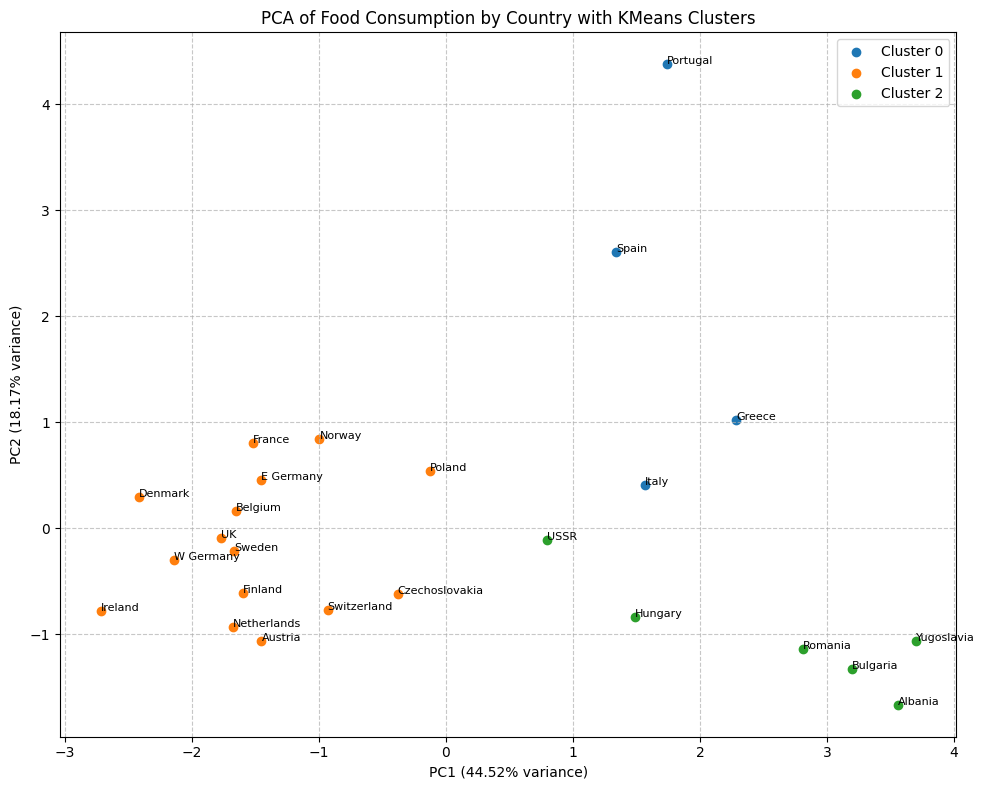

In [6]:
pca = PCA(n_components=2) # for dim reduction
X_pca = pca.fit_transform(X_scaled) # using ndarray here instead the df!

# create df with PCA results
pca_df = pd.    DataFrame(data=X_pca, columns=['PC1', 'PC2'], index=food.index)
pca_df['Cluster'] = cluster_labels

# PCA score plot with KMeans cluster labels
plt.figure(figsize=(10, 8))
for cluster in range(best_k):
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}')

# country names annotation for semantics
for i, country in enumerate(pca_df.index):
    plt.annotate(country, (pca_df.iloc[i, 0], pca_df.iloc[i, 1]), fontsize=8)


plt.title('PCA of Food Consumption by Country with KMeans Clusters')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

On the score plot of the `PCA` you can see the three clusters distributed on the two orthogonal principal components: 
- in blue, we can see mediterranean countries clustered together. Notice the outlier Portugal (as discovered in the `PCA` session  already, yielding an extreme fish consumption compared to other countries)
- In yellow belonging to cluster 1, we can see central- and western european countries.
- In green we can see eastern european countries clustered together

Generally, the `KMeans` algorithm did a great job on clustering these data points to 3 clusters together. Note as well, that the country names are necessary for semantic interpretation!! 

### Hierarchical Clustering


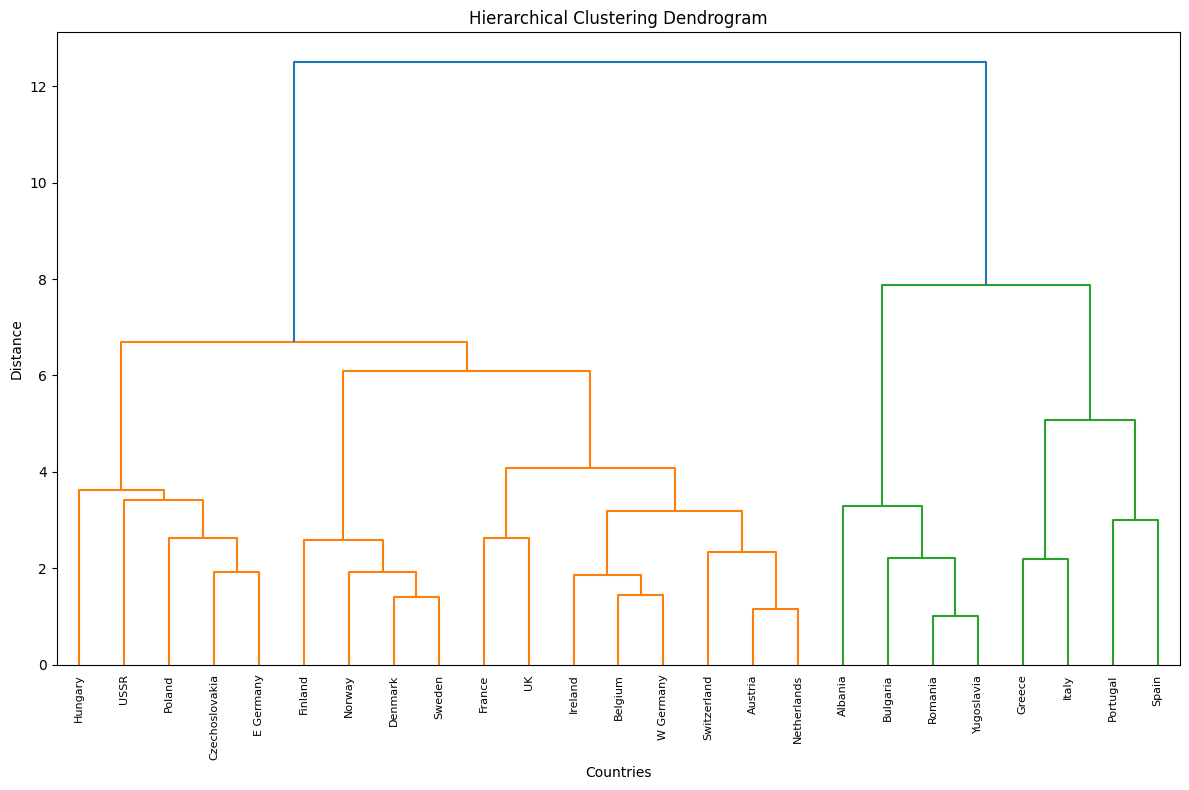

In [59]:
# compute linkage matrix
Z = linkage(X_scaled, method='ward')

# plot dendrogram
plt.figure(figsize=(12, 8))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Countries')
plt.ylabel('Distance')

dendrogram(
    Z,
    leaf_rotation=90,  # rotates the x axis labels
    leaf_font_size=8,  # font size for the x axis labels
    labels=food.index
)
plt.tight_layout()
plt.show()

In the dendrogram, we can observe two major clusters, based on a top-down reading approach. In the yellow cluster, central european and scandinavian countries are included. In the green cluster, south european and east-european.

I personally find the separation in two clusters a little too broad, I'd cut the dendrogramm to have more assigned clusters towards the subclusters in the above dendrogramm (eg.: all scandinavian countries in one subcluster). Instead of "cutting the tree" another approach would just be the reading of the dendrogram bottom-up where as mentioned in the sentence before, the subclusters are visisble (e.g. scandinavia vs central europe within the orange cluster). 

### Clustered heatmap

<Figure size 1400x1000 with 0 Axes>

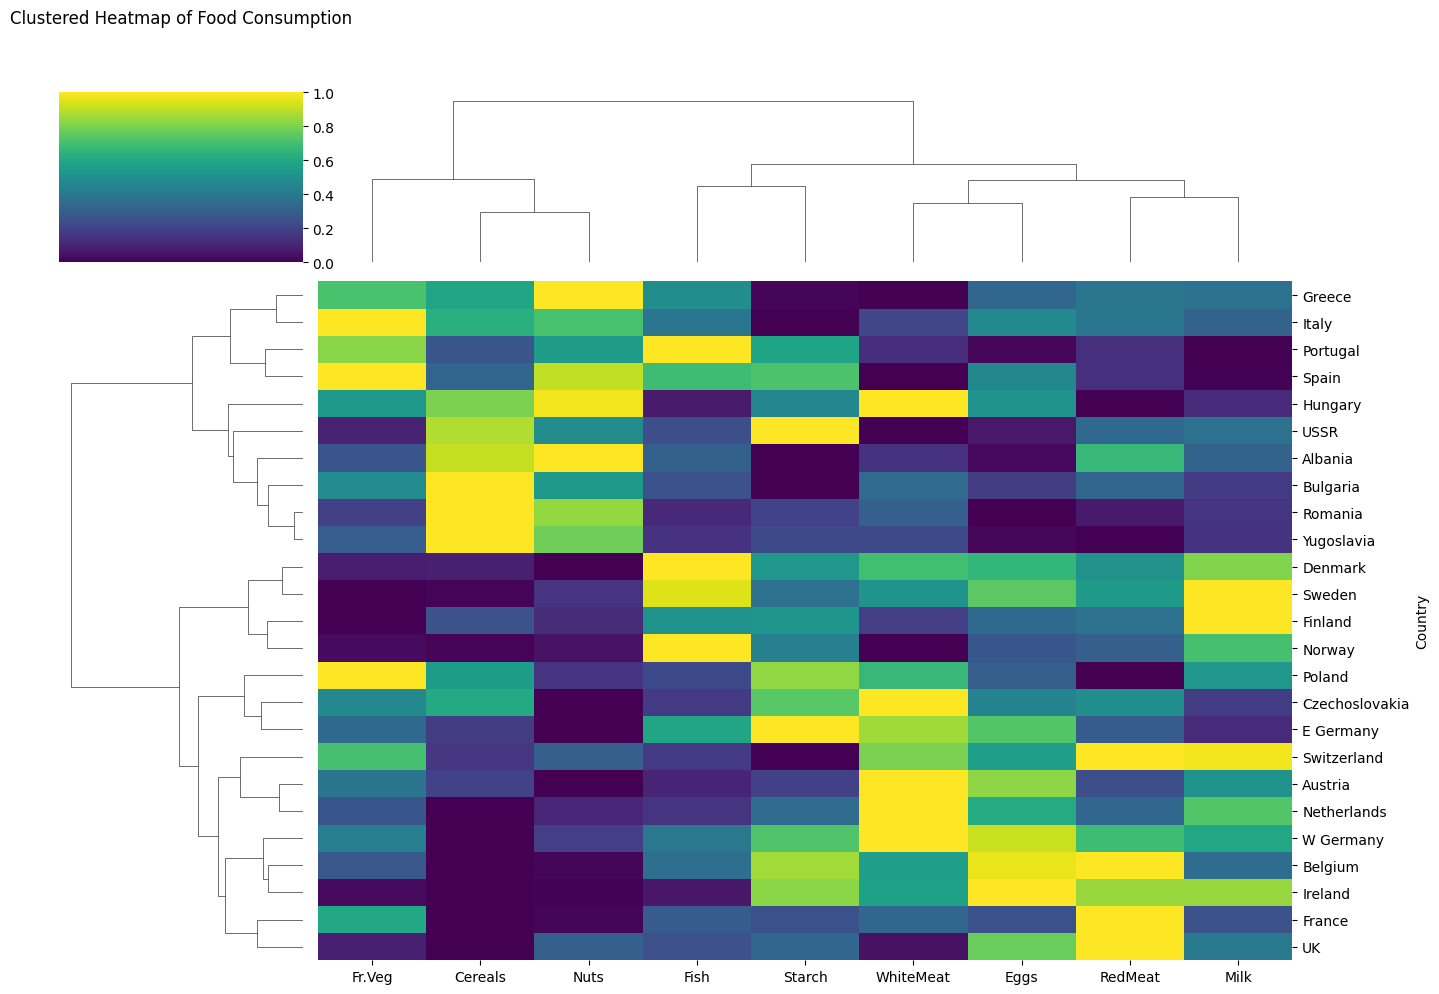

In [8]:
# clustered heatmap
plt.figure(figsize=(14, 10))
sns.clustermap(
    X_scaled_df,
    method='ward',
    cmap='viridis',
    standard_scale=0,  # 0, cuz we already scaled!
    figsize=(14, 10),
    xticklabels=True,
    yticklabels=True
)
plt.title('Clustered Heatmap of Food Consumption', pad=50)
plt.tight_layout()
plt.show()

Observing the cluster heatmap, we can obtain interesting findings such as the high fish consumption for portugal resulting as an "outlier" in the `PCA` score plot with two principal components. 

Other findings include the high cereal and nuts consumption for "east european" countries (e.g. Albania, bulgaria, romania)

### DBSCAN clustering

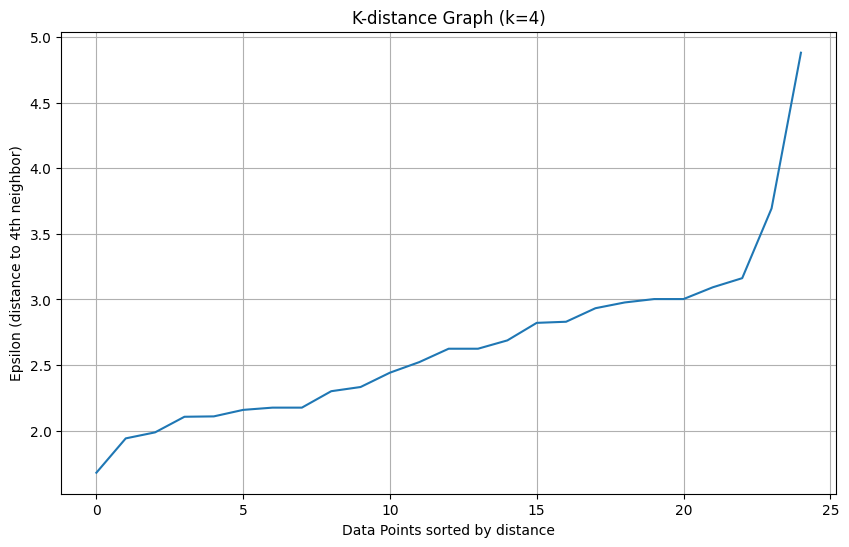

In [53]:
# find best eps param using the k-distance graph
k = 4 # number of neighbors to consider
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(X_scaled)
dist, indices = neigh.kneighbors(X_scaled)
dist = np.sort(dist[:, k-1])

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(dist)
plt.title('K-distance Graph (k={})'.format(k))
plt.xlabel('Data Points sorted by distance')
plt.ylabel('Epsilon (distance to {}th neighbor)'.format(k))
plt.grid(True)
plt.show()

# Based on the plot, we can select an optimal eps value at the "elbow"
# satisfying result by manually adjusting eps and min_samples
    # eps 2.75
    # min_samples 2
    
eps = 2.8
min_samples = 2

Number of clusters: 3
Number of noise points: 2


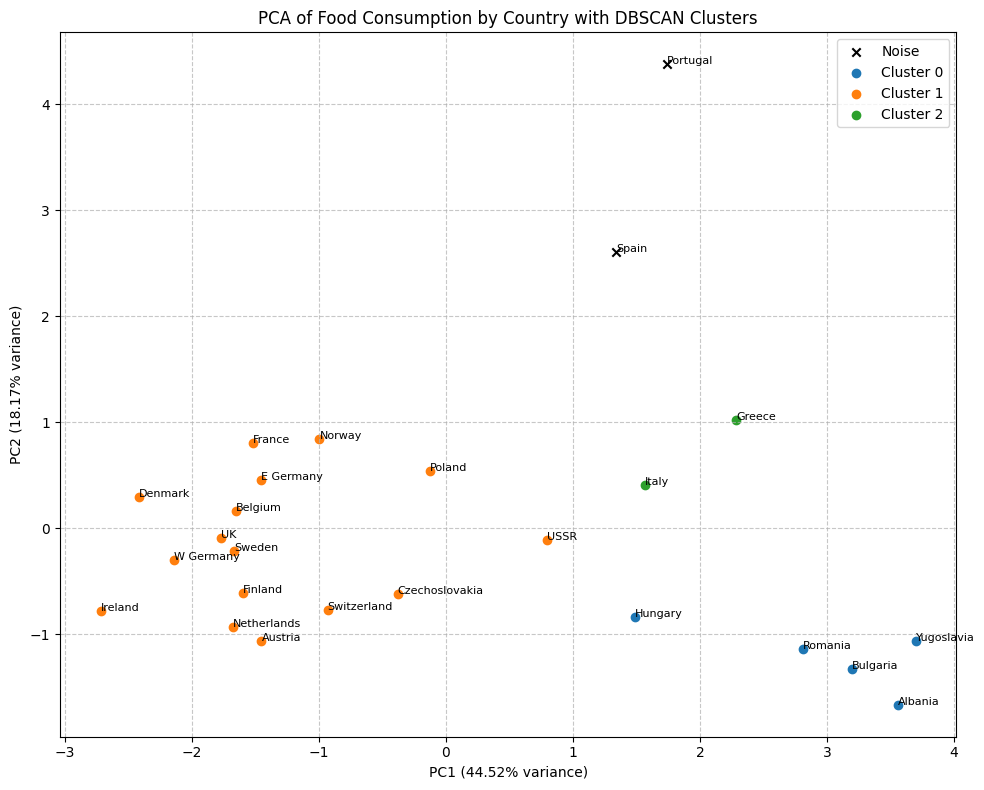

In [54]:
# setup & apply DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X_scaled)

# add DBSCAN cluster labels to the original df
food['DBSCAN_Cluster'] = dbscan_labels

# print number of clusters and noise points
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)
print(f'Number of clusters: {n_clusters}')
print(f'Number of noise points: {n_noise}')

# visualize DBSCAN results using PCA
pca_df['DBSCAN_Cluster'] = dbscan_labels
plt.figure(figsize=(10, 8))
# Plot noise points first
noise = pca_df[pca_df['DBSCAN_Cluster'] == -1]
plt.scatter(noise['PC1'], noise['PC2'], color='black', marker='x', label='Noise')

# plot clusters
for cluster in set(dbscan_labels) - {-1}:
    cluster_data = pca_df[pca_df['DBSCAN_Cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}')

# add country names for semantics
for i, country in enumerate(pca_df.index):
    plt.annotate(country, (pca_df.iloc[i, 0], pca_df.iloc[i, 1]), fontsize=8)
    
plt.title('PCA of Food Consumption by Country with DBSCAN Clusters')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

After iteratively testing different combinations for $k$ visually via the elbow plot, yielding the "most beautiful elbow" where $\epsilon$ be read from. Starting with $\epsilon = 3.1$. With that value all datapoints belonged to one single cluster, therefore, I did set a smaller epsilon of 2.8. The `min_sample` param with the respect to the small sample size would also make more sense if smaller, where after testing several values, `min_samples` = 2 yielded the results visible in the score plot above.

We can see that Spain and Portugal are considered as noise, as they are that far away from Italy and Greece (the south-european cluster), not being in the radius of this cluster ($\epsilon$).